In [1]:
# Compatibility layer between Python 2 and Python 3
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())


def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df


def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan


# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma


def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()


def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y,z acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels


In [3]:
import pickle
def read_h5():
    lst = []
    with open("X and Y Dataset/x_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_train.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/x_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    with open("X and Y Dataset/y_test.pickle", "rb") as input_file:
        lst.append(pickle.load(input_file))
    return lst
def read_properties():
    lst = None
    with open('X and Y Dataset/properties.pickle','rb+') as fd:
        lst = pickle.load(fd)
    return lst
x_train,y_train,x_test,y_test = read_h5()

In [4]:
x_train

array([[-0.013259, -0.096782, -0.130589, ..., -0.135169,  0.122678,
         0.962112],
       [ 0.116003,  0.127935,  0.255208, ..., -0.215388, -0.327122,
         1.042331],
       [ 0.199526,  0.255208, -0.214112, ..., -0.135169,  0.446419,
         1.388992],
       ...,
       [ 1.211427,  1.189527,  1.199747, ...,  0.388914,  0.3805  ,
         0.397328],
       [ 1.199747,  1.199747,  1.211427, ...,  0.388914,  0.3805  ,
         0.3805  ],
       [ 1.205587,  1.199747,  1.199747, ...,  0.405741,  0.420466,
         0.412052]], dtype=float32)

In [5]:
TIME_PERIODS = 80
num_time_periods, num_sensors,num_classes,input_shape = read_properties()


In [6]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%


--- Create neural network model ---

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 2, 160)            256160    
_________________________________________________________________
global_average_p

In [7]:
print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])



--- Fit the model ---



In [8]:
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)


Train on 16694 samples, validate on 4174 samples
Epoch 1/50
16694/16694 [==============================] - 8s 492us/step - loss: 0.7956 - accuracy: 0.7029 - val_loss: 0.5656 - val_accuracy: 0.8167
Epoch 2/50
  400/16694 [..............................] - ETA: 7s - loss: 0.4938 - accuracy: 0.8150

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 8s 483us/step - loss: 0.3966 - accuracy: 0.8524 - val_loss: 0.5472 - val_accuracy: 0.8150
Epoch 3/50
16694/16694 [==============================] - 8s 493us/step - loss: 0.2515 - accuracy: 0.9124 - val_loss: 0.5891 - val_accuracy: 0.8131
Epoch 4/50
16694/16694 [==============================] - 8s 494us/step - loss: 0.1866 - accuracy: 0.9395 - val_loss: 0.5930 - val_accuracy: 0.8256
Epoch 5/50
16694/16694 [==============================] - 8s 495us/step - loss: 0.1542 - accuracy: 0.9505 - val_loss: 0.6761 - val_accuracy: 0.7813
Epoch 6/50
16694/16694 [==============================] - 8s 494us/step - loss: 0.1409 - accuracy: 0.9545 - val_loss: 0.7217 - val_accuracy: 0.7669
Epoch 7/50
16694/16694 [==============================] - 8s 497us/step - loss: 0.1268 - accuracy: 0.9615 - val_loss: 0.6856 - val_accuracy: 0.8170
Epoch 8/50
16694/16694 [==============================] - 8s 499us/step - loss: 0.1123 - accuracy: 0.9630 - val_loss: 0.610

In [9]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


--- Learning curve of model training ---



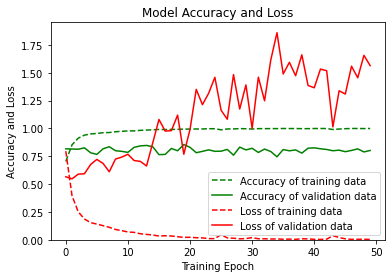

In [10]:
print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [12]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])



--- Check against test data ---

6584/6584 [==============================] - 1s 165us/step

Accuracy on test data: 0.91

Loss on test data: 0.93



--- Confusion matrix for test data ---



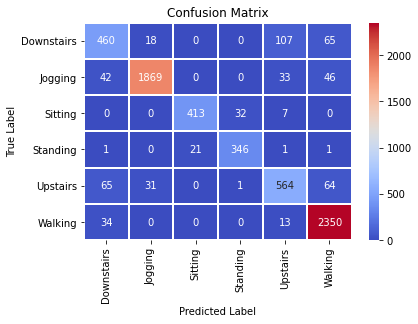

In [14]:
print("\n--- Confusion matrix for test data ---\n")
LABELS = ["Downstairs",
          "Jogging",
          "Sitting",
          "Standing",
          "Upstairs",
          "Walking"]
y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [15]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       650
           1       0.97      0.94      0.96      1990
           2       0.95      0.91      0.93       452
           3       0.91      0.94      0.92       370
           4       0.78      0.78      0.78       725
           5       0.93      0.98      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.88      6584
weighted avg       0.91      0.91      0.91      6584




--- Create neural network model ---

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 62, 100)           100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 20, 100)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 11, 160)           160160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_2 (Dropo

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 7s 439us/step - loss: 0.4841 - accuracy: 0.8221 - val_loss: 0.5990 - val_accuracy: 0.8069
Epoch 3/25
16694/16694 [==============================] - 8s 455us/step - loss: 0.3576 - accuracy: 0.8702 - val_loss: 0.5580 - val_accuracy: 0.8095
Epoch 4/25
16694/16694 [==============================] - 7s 442us/step - loss: 0.2703 - accuracy: 0.9067 - val_loss: 0.4941 - val_accuracy: 0.8275
Epoch 5/25
16694/16694 [==============================] - 7s 443us/step - loss: 0.2259 - accuracy: 0.9219 - val_loss: 0.5558 - val_accuracy: 0.8198
Epoch 6/25
16694/16694 [==============================] - 7s 445us/step - loss: 0.1970 - accuracy: 0.9326 - val_loss: 0.5841 - val_accuracy: 0.8201
Epoch 7/25
16694/16694 [==============================] - 7s 447us/step - loss: 0.1801 - accuracy: 0.9398 - val_loss: 0.5418 - val_accuracy: 0.8234
Epoch 8/25
16694/16694 [==============================] - 8s 451us/step - loss: 0.1674 - accuracy: 0.9438 - val_loss: 0.561

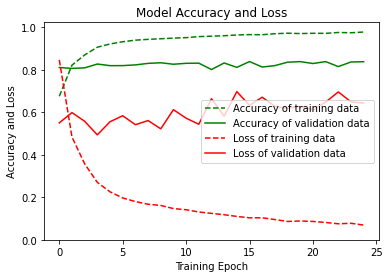

In [16]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(Conv1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()




--- Check against test data ---

6584/6584 [==============================] - 1s 161us/step

Accuracy on test data: 0.92

Loss on test data: 0.38

--- Confusion matrix for test data ---



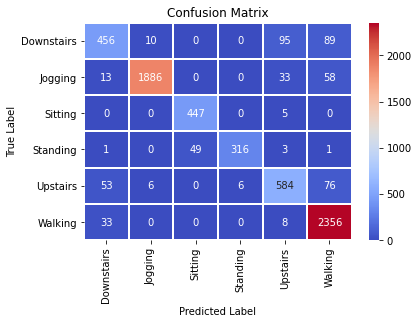

In [17]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

In [18]:
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.70      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.90      0.99      0.94       452
           3       0.98      0.85      0.91       370
           4       0.80      0.81      0.80       725
           5       0.91      0.98      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584




--- Create neural network model ---

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_3 (Dense) 

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 4s 238us/step - loss: 0.5707 - accuracy: 0.7766 - val_loss: 0.5313 - val_accuracy: 0.8146
Epoch 3/25
16694/16694 [==============================] - 4s 218us/step - loss: 0.4623 - accuracy: 0.8313 - val_loss: 0.5242 - val_accuracy: 0.8225
Epoch 4/25
16694/16694 [==============================] - 3s 203us/step - loss: 0.3995 - accuracy: 0.8567 - val_loss: 0.5159 - val_accuracy: 0.8376
Epoch 5/25
16694/16694 [==============================] - 3s 203us/step - loss: 0.3545 - accuracy: 0.8753 - val_loss: 0.5032 - val_accuracy: 0.8385
Epoch 6/25
16694/16694 [==============================] - 4s 257us/step - loss: 0.3204 - accuracy: 0.8894 - val_loss: 0.5049 - val_accuracy: 0.8328
Epoch 7/25
16694/16694 [==============================] - 4s 215us/step - loss: 0.2975 - accuracy: 0.8960 - val_loss: 0.5010 - val_accuracy: 0.8330
Epoch 8/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2737 - accuracy: 0.9060 - val_loss: 0.573

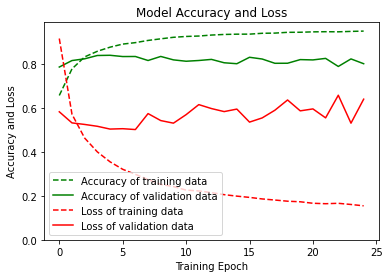

In [19]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()





--- Check against test data ---

6584/6584 [==============================] - 0s 73us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



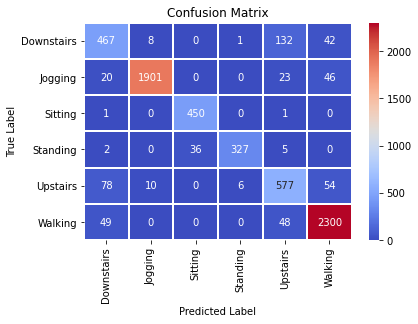


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.72      0.74       650
           1       0.99      0.96      0.97      1990
           2       0.93      1.00      0.96       452
           3       0.98      0.88      0.93       370
           4       0.73      0.80      0.76       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.89      0.88      0.89      6584
weighted avg       0.92      0.91      0.92      6584



In [20]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_4 ( (None, 160)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_4 (Dense) 

/Users/narengs7/Anaconda/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


16694/16694 [==============================] - 3s 193us/step - loss: 0.5092 - accuracy: 0.8103 - val_loss: 0.5313 - val_accuracy: 0.8464
Epoch 3/25
16694/16694 [==============================] - 3s 199us/step - loss: 0.4147 - accuracy: 0.8502 - val_loss: 0.5705 - val_accuracy: 0.8165
Epoch 4/25
16694/16694 [==============================] - 4s 231us/step - loss: 0.3518 - accuracy: 0.8747 - val_loss: 0.5481 - val_accuracy: 0.8273
Epoch 5/25
16694/16694 [==============================] - 3s 204us/step - loss: 0.3047 - accuracy: 0.8933 - val_loss: 0.5174 - val_accuracy: 0.8256
Epoch 6/25
16694/16694 [==============================] - 3s 185us/step - loss: 0.2777 - accuracy: 0.9047 - val_loss: 0.5246 - val_accuracy: 0.8294
Epoch 7/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2527 - accuracy: 0.9136 - val_loss: 0.5306 - val_accuracy: 0.8287
Epoch 8/25
16694/16694 [==============================] - 3s 187us/step - loss: 0.2360 - accuracy: 0.9193 - val_loss: 0.583

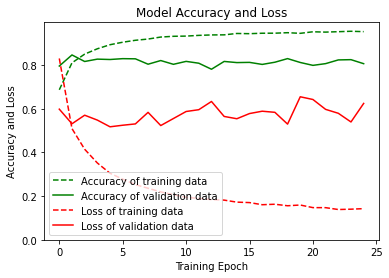

In [21]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 300
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()






--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.91

Loss on test data: 0.37

--- Confusion matrix for test data ---



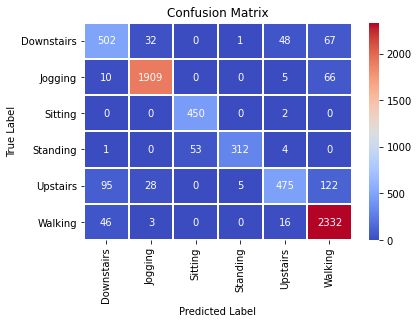


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       650
           1       0.97      0.96      0.96      1990
           2       0.89      1.00      0.94       452
           3       0.98      0.84      0.91       370
           4       0.86      0.66      0.75       725
           5       0.90      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584



In [22]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_7 ( (None, 160)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_7 (Dense) 

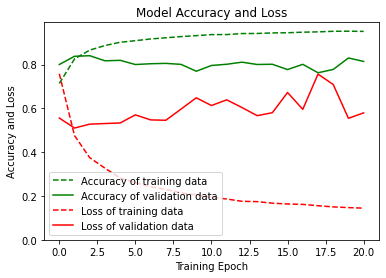

In [26]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
#         filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss'),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 200
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()







--- Check against test data ---

6584/6584 [==============================] - 0s 67us/step

Accuracy on test data: 0.90

Loss on test data: 0.36

--- Confusion matrix for test data ---



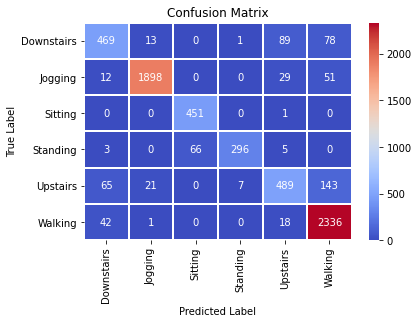


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.79      0.72      0.76       650
           1       0.98      0.95      0.97      1990
           2       0.87      1.00      0.93       452
           3       0.97      0.80      0.88       370
           4       0.77      0.67      0.72       725
           5       0.90      0.97      0.93      2397

    accuracy                           0.90      6584
   macro avg       0.88      0.85      0.86      6584
weighted avg       0.90      0.90      0.90      6584



In [27]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_6 ( (None, 160)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_6 (Dense) 

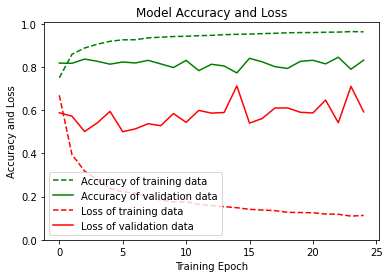

In [24]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 100
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()








--- Check against test data ---

6584/6584 [==============================] - 0s 75us/step

Accuracy on test data: 0.91

Loss on test data: 0.36

--- Confusion matrix for test data ---



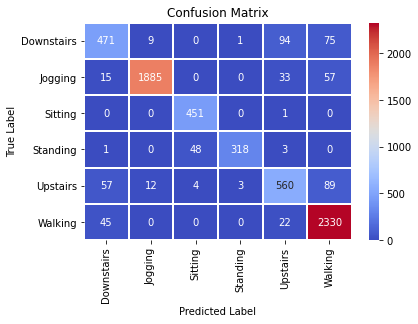


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.80      0.72      0.76       650
           1       0.99      0.95      0.97      1990
           2       0.90      1.00      0.94       452
           3       0.99      0.86      0.92       370
           4       0.79      0.77      0.78       725
           5       0.91      0.97      0.94      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.91      0.91      0.91      6584



In [25]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_8 ( (None, 160)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_8 (Dense) 

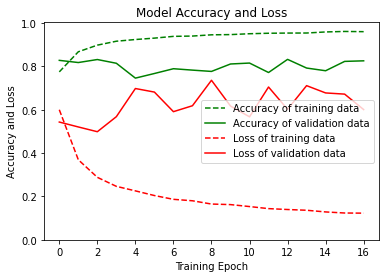

In [28]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 50
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()









--- Check against test data ---

6584/6584 [==============================] - 0s 76us/step

Accuracy on test data: 0.92

Loss on test data: 0.34

--- Confusion matrix for test data ---



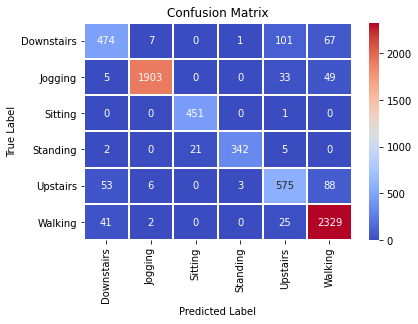


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       650
           1       0.99      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       0.99      0.92      0.96       370
           4       0.78      0.79      0.78       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.91      0.90      0.90      6584
weighted avg       0.92      0.92      0.92      6584



In [29]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_9 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 23, 100)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 160)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 160)               0         
_________________________________________________________________
dense_9 (Dense) 

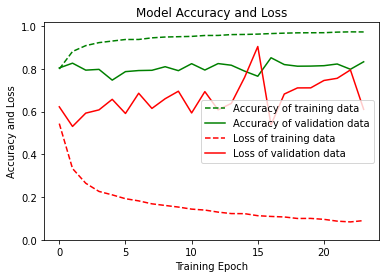

In [30]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()










--- Check against test data ---

6584/6584 [==============================] - 1s 79us/step

Accuracy on test data: 0.93

Loss on test data: 0.38

--- Confusion matrix for test data ---



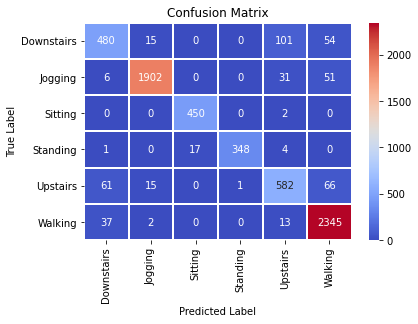


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       650
           1       0.98      0.96      0.97      1990
           2       0.96      1.00      0.98       452
           3       1.00      0.94      0.97       370
           4       0.79      0.80      0.80       725
           5       0.93      0.98      0.95      2397

    accuracy                           0.93      6584
   macro avg       0.92      0.90      0.91      6584
weighted avg       0.93      0.93      0.93      6584



In [31]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_11 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_11  (None, 160)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_11 (Dense

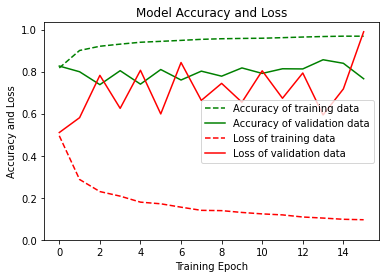

In [34]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 10
EPOCHS = 25

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 81us/step

Accuracy on test data: 0.92

Loss on test data: 0.34

--- Confusion matrix for test data ---



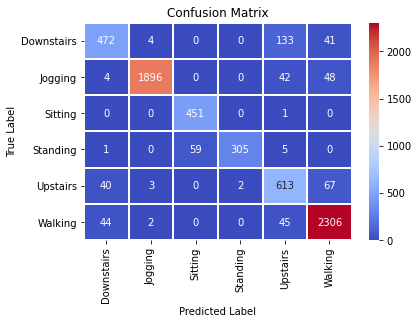


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.84      0.73      0.78       650
           1       1.00      0.95      0.97      1990
           2       0.88      1.00      0.94       452
           3       0.99      0.82      0.90       370
           4       0.73      0.85      0.78       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.92      6584



In [35]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_12  (None, 160)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_12 (Dense

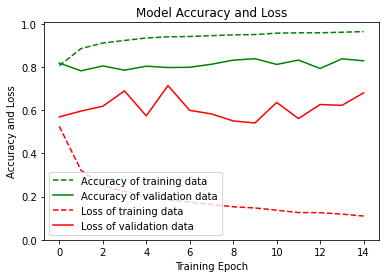

In [36]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 15

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 104us/step

Accuracy on test data: 0.92

Loss on test data: 0.38

--- Confusion matrix for test data ---



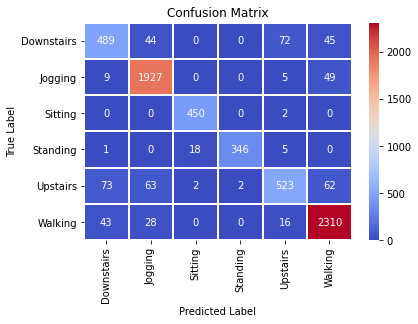


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.80      0.75      0.77       650
           1       0.93      0.97      0.95      1990
           2       0.96      1.00      0.98       452
           3       0.99      0.94      0.96       370
           4       0.84      0.72      0.78       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.92      6584
   macro avg       0.91      0.89      0.90      6584
weighted avg       0.92      0.92      0.92      6584



In [37]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_13  (None, 160)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_13 (Dense

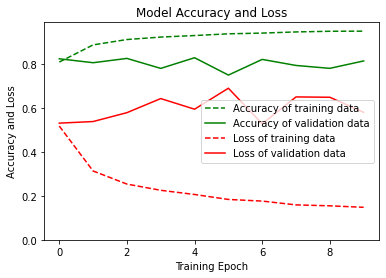

In [38]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 1s 80us/step

Accuracy on test data: 0.91

Loss on test data: 0.38

--- Confusion matrix for test data ---



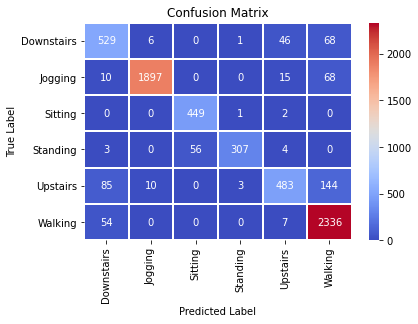


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       650
           1       0.99      0.95      0.97      1990
           2       0.89      0.99      0.94       452
           3       0.98      0.83      0.90       370
           4       0.87      0.67      0.75       725
           5       0.89      0.97      0.93      2397

    accuracy                           0.91      6584
   macro avg       0.90      0.87      0.88      6584
weighted avg       0.91      0.91      0.91      6584



In [39]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_14  (None, 160)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_14 (Dense

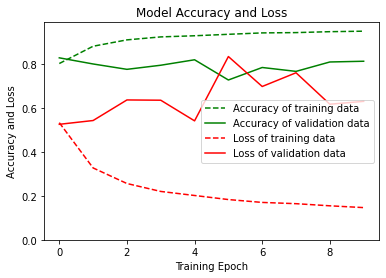

In [40]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()


--- Check against test data ---

6584/6584 [==============================] - 0s 72us/step

Accuracy on test data: 0.91

Loss on test data: 0.33

--- Confusion matrix for test data ---



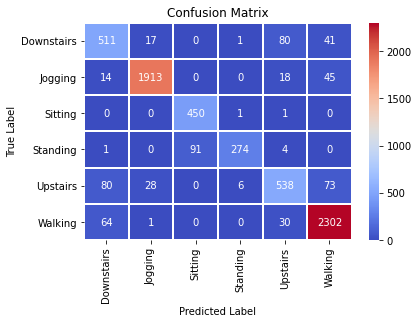


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       650
           1       0.98      0.96      0.97      1990
           2       0.83      1.00      0.91       452
           3       0.97      0.74      0.84       370
           4       0.80      0.74      0.77       725
           5       0.94      0.96      0.95      2397

    accuracy                           0.91      6584
   macro avg       0.88      0.86      0.87      6584
weighted avg       0.91      0.91      0.91      6584



In [41]:
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))


--- Create neural network model ---

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 80, 3)             0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 71, 100)           3100      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 23, 100)           0         
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 14, 160)           160160    
_________________________________________________________________
global_average_pooling1d_16  (None, 160)               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_16 (Dense

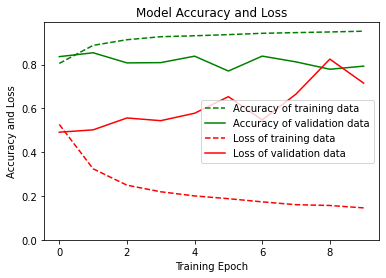


--- Check against test data ---

6584/6584 [==============================] - 1s 171us/step

Accuracy on test data: 0.92

Loss on test data: 0.35

--- Confusion matrix for test data ---



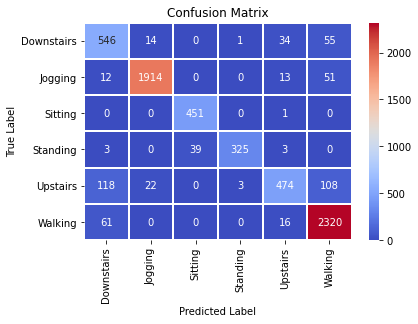


--- Classification report for test data ---

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       650
           1       0.98      0.96      0.97      1990
           2       0.92      1.00      0.96       452
           3       0.99      0.88      0.93       370
           4       0.88      0.65      0.75       725
           5       0.92      0.97      0.94      2397

    accuracy                           0.92      6584
   macro avg       0.90      0.88      0.89      6584
weighted avg       0.92      0.92      0.91      6584



In [43]:
print("\n--- Create neural network model ---\n")

# 1D CNN neural network
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())
# Accuracy on training data: 99%
# Accuracy on test data: 91%

print("\n--- Fit the model ---\n")

# The EarlyStopping callback monitors training accuracy:
# if it fails to improve for two consecutive epochs,
# training stops early
callbacks_list = [
    keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 25
EPOCHS = 10

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

print("\n--- Learning curve of model training ---\n")

# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
print("\n--- Check against test data ---\n")

score = model_m.evaluate(x_test, y_test, verbose=1)

print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])

print("\n--- Confusion matrix for test data ---\n")

y_pred_test = model_m.predict(x_test)
# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)
print("\n--- Classification report for test data ---\n")

print(classification_report(max_y_test, max_y_pred_test))